In [1]:
from config import *

In [2]:
print(f'{year}年{month}月')

2020年6月


# Developer Salary in First-Tier Cities 程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [3]:
import pandas as pd
import sys
sys.path.append('..')
sys.path.append('../py')
sys.path.append('../../py')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
import scipy.stats as stats
import numpy as np
import weighted
%matplotlib inline

In [4]:
conn=db.get_conn()
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and city in ('北京','上海','广州','深圳')  and monthly_salary<80000", con=conn)
conn.close()

In [5]:
data=data_original

In [6]:
#del data['publish_date']
#del data['published_on_weekend']
#del data['title']
#del data['title']
#del data['company_title']
#del data['company_description']
#del data['job_description']
#del data['job_id']

In [7]:
data=data.sort_values(by='headcount', ascending=False)
data.head()

,job_id,monthly_salary,headcount,title,zhinengleibie,career,real_province,province,city,company_id,...,bd_hbase,bd_storm,bd_pig,bd_mahout,bd_impala,bd_yarn,bd_alluxio,bd_flink,bd_presto,bd_heron
34170,121349025,17500,100,Java开发工程师,Java开发工程师,软件工程师,None,北京,北京,co5835770,...,False,False,False,False,False,False,False,False,False,False
15737,117792359,12500,100,Java中级软件工程师,软件工程师,软件工程师,None,北京,北京,co110997,...,False,False,False,False,False,False,False,False,False,False
34167,121349022,17500,100,Java开发工程师,Java开发工程师,软件工程师,None,上海,上海,co5835770,...,False,False,False,False,False,False,False,False,False,False
34168,121349023,17500,100,Java开发工程师,Java开发工程师,软件工程师,None,广东,深圳,co5835770,...,False,False,False,False,False,False,False,False,False,False
34169,121349024,17500,100,Java开发工程师,Java开发工程师,软件工程师,None,广东,广州,co5835770,...,False,False,False,False,False,False,False,False,False,False


In [8]:
def pd_weighted_mean(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [9]:
data.shape

(51255, 114)

In [10]:
data.headcount.sum()

150049

In [11]:
salary_mean=weighted.weighted_mean(data.monthly_salary.values, data.headcount.values)
q=weighted.weighted_quantile(data.monthly_salary.values,[0.025,0.25,0.5,0.75,0.975], data.headcount.values)
q

array([ 6500., 12000., 15000., 20000., 37500.])

In [12]:
print(f'{year}年{month}月中国一线城市程序员的平均工资为{salary_mean:.0f}元，工资中位数为{q[2]:.0f}元，其中95%的人的工资位于{q[0]:.0f}到{q[4]:.0f}元之间。')

2020年6月中国一线城市程序员的平均工资为16855元，工资中位数为15000元，其中95%的人的工资位于6500到37500元之间。


In [13]:
print(f'In {year}, Developers in China earn {salary_mean:.0f} Yuan as average, '
      f'the median is {q[2]:.0f} Yuan, 95% of them earn between {q[0]:.0f} and {q[4]:.0f} Yuan.')

In 2020, Developers in China earn 16855 Yuan as average, the median is 15000 Yuan, 95% of them earn between 6500 and 37500 Yuan.


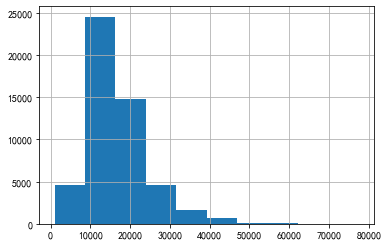

In [14]:
data.monthly_salary.hist()
plt.show()

It does not look like normal distribution.

In [15]:
from scipy import stats

In [16]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=18466.939918883647, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

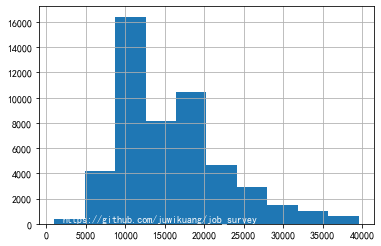

In [17]:
data[data.monthly_salary<40000].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(2000, 100), color='white')
plt.show()

## Role 角色

In [18]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]
    

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(weighted.weighted_mean(values, weights))
        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
    {"salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}","percentage":"{:.2%}"})

In [19]:
data_career = get_sub_stats_by_col(data,'career')
data_career.style.format({"salary_mean":"{:.0f}","salary_median":"{:.0f}","percentage":"{:.2%}"})

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
46,敏捷教练,45000,45000.000000,45000,45000.000000,10,0.01%
40,推荐算法工程师,37967,22500.000000,32944,65000.000000,95,0.06%
54,CTO,36042,14375.000000,37083,68562.400000,26,0.02%
57,反作弊算法工程师,35062,13000.000000,37857,40000.000000,8,0.01%
49,搜索算法工程师,32545,4725.000000,25000,75000.000000,66,0.04%
50,芯片,31464,9587.500000,27500,62500.000000,88,0.06%
53,编译器开发工程师,31358,18000.000000,31250,42500.000000,20,0.01%
52,数据科学家,30205,4479.166667,28750,74652.750000,110,0.07%
6,架构师,29593,11670.000000,29000,55000.000000,3888,2.59%
55,SLAM,26583,12500.000000,29250,30000.000000,18,0.01%


In [20]:
np.sum(data.monthly_salary * data.headcount) / data.headcount.sum()

16855.413411618872

In [21]:
data.headcount.sum()

150049

In [22]:
data.headcount.describe()

count    51255.000000
mean         2.927500
std          2.795304
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        100.000000
Name: headcount, dtype: float64

In [23]:
pd.options.display.max_columns=100


In [24]:
data.headcount.sum()

150049

# 城市

In [25]:
headcount_by_cities = data.groupby(by='city').headcount.sum()

In [26]:
headcount_by_cities


city
上海    50209
北京    23986
广州    32044
深圳    43810
Name: headcount, dtype: int64

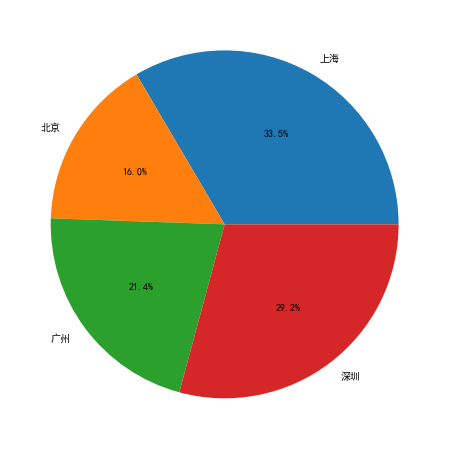

In [27]:
plt.figure(figsize=(10,8))
plt.pie(headcount_by_cities.values, labels=headcount_by_cities.index, autopct='%1.1f%%')
plt.show()

In [28]:
data_pl=get_sub_stats_by_col(data,'city')
apply_style(data_pl)

city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,19082,7000,17500,45000,23986,15.99%
上海,17382,7000,15500,37500,50209,33.46%
深圳,16952,7000,15000,37500,43810,29.20%
广州,14233,5250,12500,30000,32044,21.36%


In [29]:
salary_beijing=data[data.city=='北京'].monthly_salary
salary_shanghai=data[data.city=='上海'].monthly_salary
salary_guangzhou=data[data.city=='广州'].monthly_salary
salary_shenzhen=data[data.city=='深圳'].monthly_salary

In [30]:
stats.f_oneway(salary_beijing, salary_shanghai)

F_onewayResult(statistic=205.48160532595708, pvalue=2.0538712238357685e-46)

In [31]:
stats.f_oneway(salary_shanghai, salary_shenzhen)

F_onewayResult(statistic=89.98462631779309, pvalue=2.5579984278351924e-21)

In [32]:
stats.f_oneway(salary_shenzhen, salary_guangzhou)

F_onewayResult(statistic=866.534633505006, pvalue=1.7504249676397344e-187)

# 编程语言

In [33]:
data_pl=get_sub_stats_by_prefix(data,'pl_')
apply_style(data_pl)

rank,pl_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,julia,24375,24375,22500,25000,4,0.00%
2,rust,24023,22500,9271,45844,233,0.10%
3,scala,22795,20000,9000,50000,1888,0.84%
4,matlab,21294,20000,9000,40000,2750,1.22%
5,python,21077,18500,7000,45000,19509,8.65%
6,go,20288,17500,7500,45000,18381,8.15%
7,r,19777,17500,7000,40000,1860,0.82%
8,lua,19594,17500,7000,40275,2758,1.22%
9,swift,19326,17500,8500,40000,1605,0.71%
10,perl,18927,17500,7000,50000,1562,0.69%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [34]:
edu_counts=data[~(data.edu=='')].groupby(by=['edu']).headcount.sum()

In [35]:
edu_counts

edu
初中及以下       16
博士         295
大专       39962
本科       95368
硕士        4110
高中         235
Name: headcount, dtype: int64

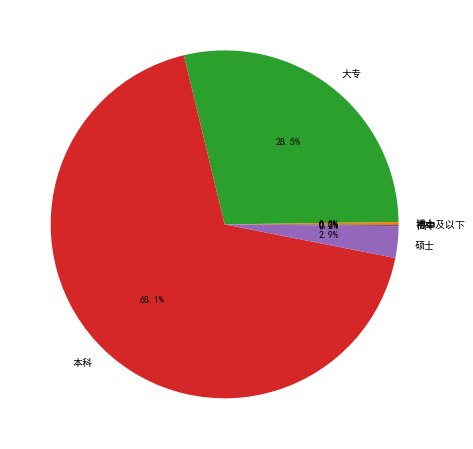

In [36]:
plt.figure(figsize=(10,8))
plt.pie(edu_counts.values, labels=edu_counts.index, autopct='%1.1f%%')
plt.show()

In [37]:
data_edu=get_sub_stats_by_col(data[data.edu.isin(['初中及以下','高中','大专','本科','硕士','博士'])], 'edu')
apply_style(data_edu)

edu,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
博士,30560,2902,30000,62500,295,0.21%
硕士,24084,9000,22500,50000,4110,2.94%
本科,17895,7000,16000,39000,95368,68.13%
大专,13780,5250,12500,29166,39962,28.55%
高中,10398,4500,9000,29490,235,0.17%
初中及以下,9609,3750,5938,27500,16,0.01%


In [38]:
salary_associate=data[data.edu=='大专'].monthly_salary
salary_bachelor=data[data.edu=='本科'].monthly_salary
salary_master=data[data.edu=='硕士'].monthly_salary
salary_phd=data[data.edu=='博士'].monthly_salary

In [39]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是13496，17701，24011，30635。中位数分别是12500， 16000，22500， 29583。


In [40]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=36.896670082132296, pvalue=1.549123744944814e-09)

In [41]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=870.3740430680201, pvalue=6.11894353838828e-189)

In [42]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=3048.6432681467486, pvalue=0.0)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

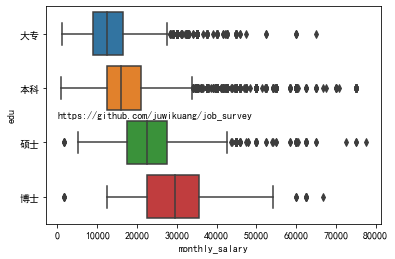

In [43]:

order=['大专','本科','硕士','博士']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [44]:
data_experience=get_sub_stats_by_col(data, 'experience')
apply_style(data_experience)

experience,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
10+,31370,10000,30000,60000,584,0.39%
5_10,22753,11500,20000,45000,24615,16.40%
3_5,17637,9000,15500,37500,57421,38.27%
,15866,5250,14000,35000,16392,10.92%
1_3,13283,5250,12500,30000,51037,34.01%


In [45]:
salary_we_10=data[data.experience=='10+'].monthly_salary
salary_we_5_10=data[data.experience=='5_10'].monthly_salary
salary_we_3_5=data[data.experience=='3_5'].monthly_salary
salary_we_1_3=data[data.experience=='1_3'].monthly_salary
salary_we_no=data[data.experience=='no'].monthly_salary

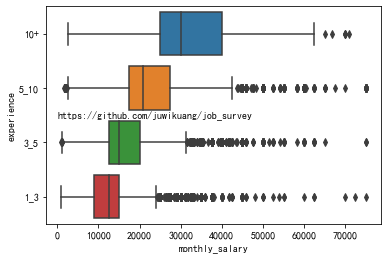

In [46]:

order=['10+','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [ ]:
data_company_type=get_sub_stats_by_col(data,'company_type')
apply_style(data_company_type)

us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [ ]:
data_company_size=get_sub_stats_by_col(data,'company_size')
apply_style(data_company_size)

公司越大，工资越高

## 行业 Industry

In [ ]:
data_industry=get_sub_stats_by_col(data,'industry')
apply_style(data_industry)